# Synthetic Store-Week Sales Data Generation

## Business Problem

A retail company wants to test a new store layout design to determine if it increases sales. The company has selected a subset of stores to receive the new layout (treatment group) while keeping other stores with the existing layout (control group).

**Research Question:** Does the new store layout lead to statistically significant increases in weekly sales?

## Key Challenges

1. **Temporal Trends:** Sales naturally vary over time due to seasonality, holidays, and market conditions
2. **Store Heterogeneity:** Different stores have different baseline sales levels and growth trajectories
3. **Treatment Timing:** The pilot is rolled out at week 53
4. **Heterogeneous Effects:** Treatment effectiveness varies by store characteristics
5. **Confounding Factors:** Need to isolate treatment effect from underlying trends

## Dataset Assumptions

### Timeline
- **Pre-treatment period:** 52 weeks (1 year of baseline data)
- **Treatment start:** Week 53 (pilot launch)
- **Post-treatment period:** 52 weeks (1 year of post-intervention data)
- **Total:** 104 weeks (2 years)

### Store Groups
- **Treatment group:** 50 stores (25%) receiving the new layout
- **Control group:** 150 stores (75%) maintaining the existing layout
- **Total:** 200 stores

### Sales Characteristics
- **Baseline sales:** Vary by store ($50K - $150K per week)
- **Store-specific growth rates:** Each store has its own pre-period trend
- **Average temporal trend:** +0.3% per week (organic growth)
- **Seasonality:** Weekly fluctuations
- **Treatment effect:** Heterogeneous based on pre-period growth trajectory
  - Stores with higher pre-period growth rates see larger treatment effects
  - Average treatment effect: ~8% lift in weekly sales
  - Range: 2% to 14% depending on store characteristics
- **Noise:** Random variation (±15% standard deviation)

## Import Required Libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Define Data Generation Parameters

In [10]:
# Timeline parameters
n_weeks_pre = 52      # Pre-treatment period
n_weeks_post = 52     # Post-treatment period
total_weeks = n_weeks_pre + n_weeks_post
treatment_start_week = 53  # Pilot starts at week 53

# Store parameters
total_stores = 200
treatment_pct = 0.25  # 25% of stores get treatment
n_stores_treatment = int(total_stores * treatment_pct)
n_stores_control = total_stores - n_stores_treatment

# Sales parameters
baseline_sales_mean = 100000  # $100K average weekly sales
baseline_sales_std = 20000    # Variation across stores (99.7% above $40K)
weekly_trend = 0.003          # 0.3% weekly growth
base_treatment_effect = 0.08  # 8% base sales lift
noise_std = 0.15              # 15% random noise

# Heterogeneous treatment effect parameters
treatment_effect_slope_coef = 2.0  # Stores with higher growth get bigger treatment effects

# Start date
start_date = datetime(2023, 1, 1)

print(f"Generating data for {total_stores} stores over {total_weeks} weeks")
print(f"Treatment group: {n_stores_treatment} stores ({treatment_pct*100:.0f}%)")
print(f"Control group: {n_stores_control} stores ({(1-treatment_pct)*100:.0f}%)")
print(f"Pilot starts at week {treatment_start_week}")
print(f"Base treatment effect: {base_treatment_effect*100:.1f}%")

Generating data for 200 stores over 104 weeks
Treatment group: 50 stores (25%)
Control group: 150 stores (75%)
Pilot starts at week 53
Base treatment effect: 8.0%


## Generate Store Characteristics

In [11]:
# Create store IDs
store_ids = [f"STORE_{i:03d}" for i in range(1, total_stores + 1)]

# Randomly assign treatment (1) and control (0)
treatment_assignment = np.random.permutation(
    [1] * n_stores_treatment + [0] * n_stores_control
)

# Generate baseline sales for each store (using normal distribution)
# With mean=100K and std=20K, 99.7% of values naturally fall above $40K
baseline_sales = np.random.normal(
    baseline_sales_mean, 
    baseline_sales_std, 
    total_stores
)

# Generate store-specific growth rates (for heterogeneous treatment effects)
# These represent the pre-period sales slope/trend for each store
store_growth_rates = np.random.normal(weekly_trend, 0.002, total_stores)

# Create store metadata
store_metadata = pd.DataFrame({
    'store_id': store_ids,
    'treatment': treatment_assignment,
    'baseline_sales': baseline_sales,
    'growth_rate': store_growth_rates
})

print(f"Treatment stores: {treatment_assignment.sum()}")
print(f"Control stores: {(1 - treatment_assignment).sum()}")
print(f"\nBaseline sales statistics:")
print(store_metadata.groupby('treatment')['baseline_sales'].describe())
print(f"\nGrowth rate statistics:")
print(store_metadata.groupby('treatment')['growth_rate'].describe())

Treatment stores: 50
Control stores: 150

Baseline sales statistics:
           count           mean           std           min           25%  \
treatment                                                                   
0          150.0  101961.632223  19152.437030  60100.768569  87460.267963   
1           50.0  108069.186266  19013.732419  66617.352818  97976.607097   

                     50%            75%            max  
treatment                                               
0          100659.118789  117519.266827  150783.254325  
1          108443.026489  120598.922216  154688.443181  

Growth rate statistics:
           count      mean       std       min       25%       50%       75%  \
treatment                                                                      
0          150.0  0.002892  0.002059 -0.002006  0.001781  0.002840  0.004354   
1           50.0  0.003554  0.001908 -0.000329  0.002071  0.003521  0.005026   

                max  
treatment            
0   

## Generate Weekly Sales Data

In [12]:
# Initialize data storage
data_records = []

# Generate data for each store and week
for store_idx, row in store_metadata.iterrows():
    store_id = row['store_id']
    is_treatment = row['treatment']
    base_sales = row['baseline_sales']
    growth_rate = row['growth_rate']
    
    for week in range(1, total_weeks + 1):
        # Calculate week date
        week_date = start_date + timedelta(weeks=week - 1)
        
        # Temporal trend component (using store-specific growth rate)
        trend_multiplier = (1 + growth_rate) ** week
        
        # Heterogeneous treatment effect (only for treatment stores after treatment start)
        treatment_multiplier = 1.0
        if is_treatment and week >= treatment_start_week:
            # Treatment effect increases with pre-period growth rate
            # Normalize growth rate to create heterogeneity
            growth_normalized = (growth_rate - weekly_trend) / 0.002
            heterogeneous_effect = base_treatment_effect * (1 + treatment_effect_slope_coef * growth_normalized)
            # Ensure treatment effect is positive and reasonable (between 2% and 14%)
            heterogeneous_effect = np.clip(heterogeneous_effect, 0.02, 0.14)
            treatment_multiplier = 1 + heterogeneous_effect
        
        # Random noise
        noise_multiplier = np.random.normal(1.0, noise_std)
        
        # Calculate sales
        sales = base_sales * trend_multiplier * treatment_multiplier * noise_multiplier
        sales = max(sales, 0)  # Ensure non-negative
        
        # Store record
        data_records.append({
            'store_id': store_id,
            'week': week,
            'week_date': week_date,
            'treatment': is_treatment,
            'post_treatment': int(week >= treatment_start_week),
            'sales': sales
        })

# Create DataFrame
df = pd.DataFrame(data_records)

print(f"Generated {len(df):,} store-week observations")
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head(10)

Generated 20,800 store-week observations

Dataset shape: (20800, 6)

First few rows:


,store_id,week,week_date,treatment,post_treatment,sales
0,STORE_001,1,2023-01-01,0,0,79087.975611
1,STORE_001,2,2023-01-08,0,0,81836.162695
2,STORE_001,3,2023-01-15,0,0,96225.751287
3,STORE_001,4,2023-01-22,0,0,92161.163825
4,STORE_001,5,2023-01-29,0,0,117060.759703
5,STORE_001,6,2023-02-05,0,0,111639.920173
6,STORE_001,7,2023-02-12,0,0,102641.115493
7,STORE_001,8,2023-02-19,0,0,79947.918120
8,STORE_001,9,2023-02-26,0,0,82820.612083
9,STORE_001,10,2023-03-05,0,0,77071.774012


## Data Quality Checks

In [13]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Basic statistics
print("\nSales statistics by group and period:")
summary = df.groupby(['treatment', 'post_treatment'])['sales'].agg([
    'count', 'mean', 'std', 'min', 'max'
])
summary.index = summary.index.set_levels(
    [['Control', 'Treatment'], ['Pre', 'Post']]
)
print(summary)

# Verify store-week combinations
assert len(df) == total_stores * total_weeks, "Missing store-week combinations!"
print(f"\n✓ All {total_stores} stores have {total_weeks} weeks of data")

Missing values:
store_id          0
week              0
week_date         0
treatment         0
post_treatment    0
sales             0
dtype: int64

Sales statistics by group and period:
                          count           mean           std           min  \
treatment post_treatment                                                     
Control   Pre              7800  110441.526288  28377.163306  32036.073705   
          Post             7800  129920.458108  39035.931223  44471.372521   
Treatment Pre              2600  119337.934138  30613.128698  41739.357806   
          Post             2600  159324.196786  51652.694596  43045.959396   

                                    max  
treatment post_treatment                 
Control   Pre             245209.385935  
          Post            313822.405569  
Treatment Pre             249991.538124  
          Post            390519.408888  

✓ All 200 stores have 104 weeks of data


## Visualize Generated Data

## Analyze Treatment Effect Heterogeneity

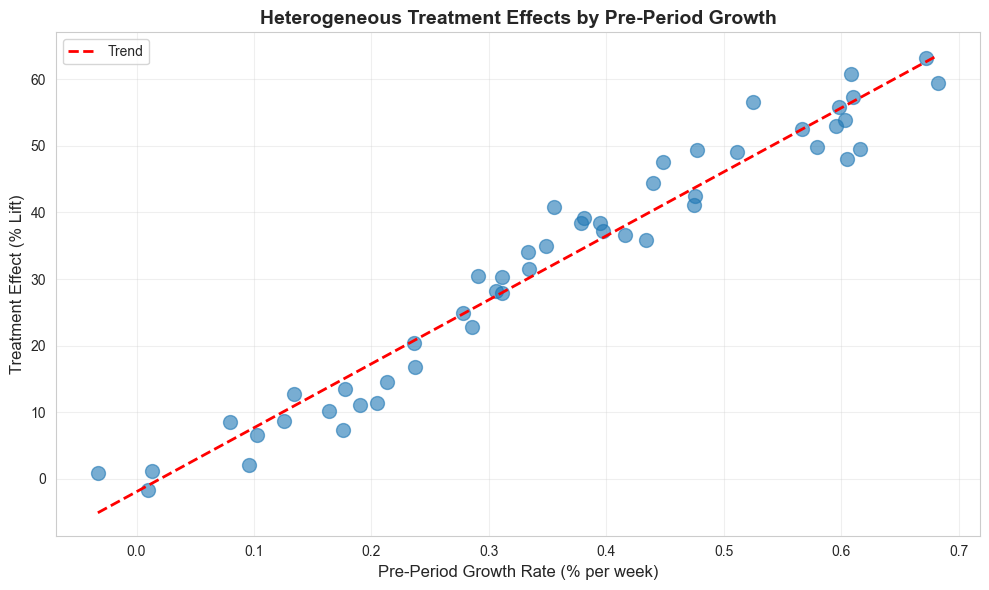

Treatment Effect Summary:
  Mean: 32.20%
  Std Dev: 18.76%
  Min: -1.69%
  Max: 63.14%

Correlation between growth rate and treatment effect: 0.976


In [14]:
# Calculate pre-period and post-period average sales for treatment stores
treatment_stores = store_metadata[store_metadata['treatment'] == 1]['store_id'].values

treatment_effects = []
for store_id in treatment_stores:
    store_data = df[df['store_id'] == store_id]
    pre_avg = store_data[store_data['week'] < treatment_start_week]['sales'].mean()
    post_avg = store_data[store_data['week'] >= treatment_start_week]['sales'].mean()
    
    # Calculate percent lift
    pct_lift = (post_avg - pre_avg) / pre_avg
    
    # Get store growth rate
    growth_rate = store_metadata[store_metadata['store_id'] == store_id]['growth_rate'].values[0]
    
    treatment_effects.append({
        'store_id': store_id,
        'growth_rate': growth_rate,
        'pct_lift': pct_lift
    })

te_df = pd.DataFrame(treatment_effects)

# Visualize relationship between growth rate and treatment effect
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(te_df['growth_rate'] * 100, te_df['pct_lift'] * 100, alpha=0.6, s=100)
ax.set_xlabel('Pre-Period Growth Rate (% per week)', fontsize=12)
ax.set_ylabel('Treatment Effect (% Lift)', fontsize=12)
ax.set_title('Heterogeneous Treatment Effects by Pre-Period Growth', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(te_df['growth_rate'], te_df['pct_lift'], 1)
p = np.poly1d(z)
x_line = np.linspace(te_df['growth_rate'].min(), te_df['growth_rate'].max(), 100)
ax.plot(x_line * 100, p(x_line) * 100, "r--", linewidth=2, label='Trend')
ax.legend()

plt.tight_layout()
plt.show()

print(f"Treatment Effect Summary:")
print(f"  Mean: {te_df['pct_lift'].mean()*100:.2f}%")
print(f"  Std Dev: {te_df['pct_lift'].std()*100:.2f}%")
print(f"  Min: {te_df['pct_lift'].min()*100:.2f}%")
print(f"  Max: {te_df['pct_lift'].max()*100:.2f}%")
print(f"\nCorrelation between growth rate and treatment effect: {te_df['growth_rate'].corr(te_df['pct_lift']):.3f}")

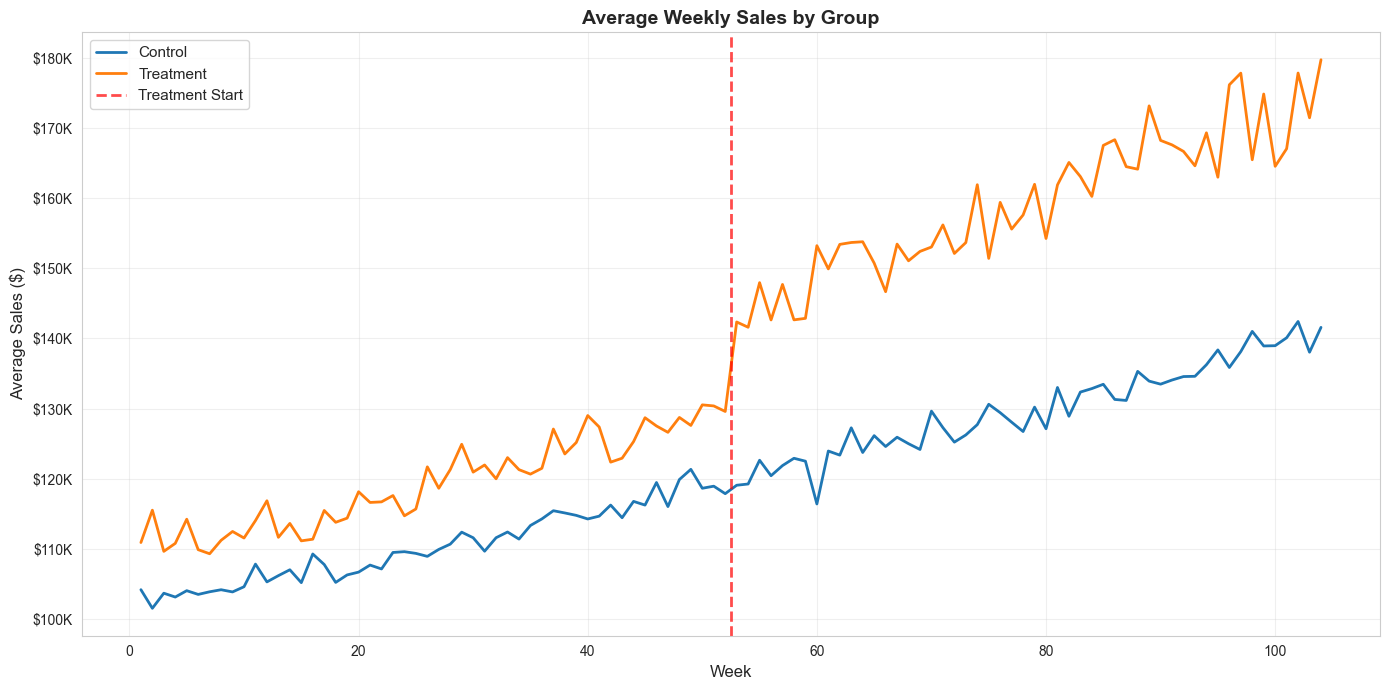


Note: The treatment effect should be visible as a gap between the lines after week 52


In [15]:
# Calculate average sales by week and group
avg_sales = df.groupby(['week', 'treatment'])['sales'].mean().reset_index()
avg_sales['group'] = avg_sales['treatment'].map({0: 'Control', 1: 'Treatment'})

# Create visualization
fig, ax = plt.subplots(figsize=(14, 7))

# Plot lines
for group in ['Control', 'Treatment']:
    data = avg_sales[avg_sales['group'] == group]
    ax.plot(data['week'], data['sales'], label=group, linewidth=2)

# Add vertical line at treatment start
ax.axvline(x=treatment_start_week - 0.5, color='red', linestyle='--', 
           linewidth=2, label='Treatment Start', alpha=0.7)

# Formatting
ax.set_xlabel('Week', fontsize=12)
ax.set_ylabel('Average Sales ($)', fontsize=12)
ax.set_title('Average Weekly Sales by Group', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Format y-axis as currency
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.show()

print("\nNote: The treatment effect should be visible as a gap between the lines after week 52")

## Save Dataset

In [16]:
# Save to CSV
output_path = '../data/store_weekly_sales.csv'
df.to_csv(output_path, index=False)
print(f"Dataset saved to: {output_path}")

# Also save store metadata
metadata_path = '../data/store_metadata.csv'
store_metadata.to_csv(metadata_path, index=False)
print(f"Store metadata saved to: {metadata_path}")

print(f"\n✓ Data generation complete!")
print(f"  - {len(df):,} observations")
print(f"  - {total_stores} stores ({n_stores_treatment} treatment, {n_stores_control} control)")
print(f"  - {total_weeks} weeks ({n_weeks_pre} pre-treatment, {n_weeks_post} post-treatment)")

Dataset saved to: ../data/store_weekly_sales.csv
Store metadata saved to: ../data/store_metadata.csv

✓ Data generation complete!
  - 20,800 observations
  - 200 stores (50 treatment, 150 control)
  - 104 weeks (52 pre-treatment, 52 post-treatment)
